In [0]:
# Jupyter-specific.
%matplotlib inline
import time
program_start = time.time()

# Colab specific.
from google.colab import files

# SciKit Learn
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
from sklearn import neighbors
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

# Keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM, GRU, CuDNNGRU, CuDNNLSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import GlobalMaxPooling1D

# General 
from collections import Counter
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
# Might need to uncomment the line below to downlaod nltk stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # Set the default styling. 
from io import BytesIO
import csv
import pickle
from scipy.sparse import coo_matrix, vstack, csr_matrix
import re
import warnings
warnings.filterwarnings('ignore')

# Plot style settings.
plt.style.use('fivethirtyeight') # I'm a fan of this one.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Reduced Data Work**

### Working with the reduced data

Reading the reduced file, taking the review and rating column

In [0]:
y = []
X = []
# open reduced CSV
with open('reduced_amazon_ff_reviews.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        X.append(row[5])
        y.append(row[8])

Making a data frame called 'df' out of column 5 and 8

In [0]:
# columns 'Rating' and 'Text' are loaded into the df
df = pd.read_csv('reduced_amazon_ff_reviews.csv', usecols=[5, 8])

# seeing the top 5 records
df.head()

,Rating,Text
0,neutral,This seems a little more wholesome than some o...
1,positive,I bought these at Grocery Outlet here in the S...
2,positive,I bought this coffee because its much cheaper ...
3,negative,Herbal additives in this blend destroy real te...
4,positive,These Nature Valley Nut Lovers Variety Pack wa...


### Setting up the data for LSTM (reduced)

Initalizing the variables for the LSTM Model. Numbers taken from the docs located [here](https://keras.io/examples/imdb_cnn_lstm/)

In [0]:
# For Embedding
max_features = 20000
maxlen = 100
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 2

Getting the data ready for emebdding, filtered out neutural reviews, number, speical characters, stopwords and converted to lowercase for better reading

In [0]:
# Removing Neutral 
df = df[df.Rating != "neutral"]

# Converting to lowercase
df['Text'] = df['Text'].apply(lambda x: str(x).lower())

# Removing numbers/special characters
df['Text'] = df['Text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))


Checking to make sure the filters worked

In [0]:
df.head()

,Rating,Text
1,positive,i bought these at grocery outlet here in the s...
2,positive,i bought this coffee because its much cheaper ...
3,negative,herbal additives in this blend destroy real te...
4,positive,these nature valley nut lovers variety pack wa...
5,negative,serveice delivery with the seller was excellen...


Printing the number of positive and negative reviews (reduced set)

In [0]:
# Number of positive
print(df[ df['Rating'] == 'positive'].size)

# Number of negative
print(df[ df['Rating'] == 'negative'].size)

13398
10834


Toeknizing the data for word embeddings. Lossely modeled after the solutions in this [link](https://stackoverflow.com/questions/55578939/tokenize-each-row-in-a-dataframe-for-loop-not-working)

In [0]:
for idx,row in df.iterrows():
    row[0] = row[0].replace('rt',' ')
    
tokenizer = Tokenizer(nb_words = max_features, split=' ')
tokenizer.fit_on_texts(df['Text'].values)
X = tokenizer.texts_to_sequences(df['Text'].values)
X = pad_sequences(X, maxlen = maxlen)

Using get_dummies to convert the categorical text data into indicator variables. Based off the documentation [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)

In [0]:
# Using the get_dummies function on the data frame
Y = pd.get_dummies(df['Rating']).values

# Split the data 80/20 and add random state 42
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)

# Print the shapes of the training and testing set
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9692, 100) (9692, 2)
(2424, 100) (2424, 2)


### LSTM Model and Results

Building the First LSTM Model. It's a sequential model with 6 layers

In [0]:
def lstmReduced1():
# Inform that the model is building
  print('Build model...')

  model = Sequential()

  # Add the embedding layer
  model.add(Embedding(max_features, embedding_size, input_length=maxlen))
  model.add(Dropout(0.25))
  # 1D Convolution Layer with Relu activation
  model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
  model.add(MaxPooling1D(pool_size=pool_size))

  # Add LSTM Layer
  model.add(LSTM(lstm_output_size))

  # Use the Softmask activiation function
  model.add(Dense(2,activation='softmax'))

  # Using categorical corss entropy and the adam optimizer
  model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

  # Print a summar of the model
  print(model.summary())

  return model

Calling the lstmReduced1 function to the variable LSTM1



In [0]:
LSTM1 = lstmReduced1()

Build model...




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 64)            41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70)                37800     
_________________________________________________________________
dense_1 (Dense)              (None, 2)           

Training the LSTM1 Model with a Batch Size of 30 and 2 Epochs

In [0]:
print('Train...')
LSTM1.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,shuffle=True, validation_data=(X_test, Y_test))
print('Model evaluation ',LSTM1.evaluate(X_test,Y_test))

Train...
Train on 9692 samples, validate on 2424 samples
Epoch 1/2
9692/9692 [==============================] - 29s 3ms/step - loss: 0.0074 - acc: 0.9975 - val_loss: 1.0409 - val_acc: 0.8259
Epoch 2/2
2424/2424 [==============================] - 1s 377us/step
Model evaluation  [1.0736800189262177, 0.8308580858085809]


Printing the test score and test accuracy

In [0]:
score, acc = LSTM1.evaluate(X_test, Y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

2424/2424 [==============================] - 1s 369us/step
Test score: 1.073680015502147
Test accuracy: 0.8308580806939909


Using the classification_report function from Scikit learn to return the main classification metrics of the model (precision, recall, f1-score, support) Based off the documentation found [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

In [0]:
LSTM1_Metrics = LSTM1.predict(X_test, verbose=2, batch_size=batch_size)
print(metrics.classification_report(Y_test[:,1], np.round(LSTM1_Metrics[:,1]), target_names =["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.80      0.84      0.82      1097
    Positive       0.86      0.82      0.84      1327

    accuracy                           0.83      2424
   macro avg       0.83      0.83      0.83      2424
weighted avg       0.83      0.83      0.83      2424



### Experimenting with Different LSTM Epochs (reduced)

Increasing the number of Epochs to find when the data starts to overfit

In [0]:
# Training with 17 more epochs
print('Train...')
historyLSTM1 = LSTM1.fit(X_train, Y_train, batch_size=batch_size, epochs=20,shuffle=True, validation_data=(X_test, Y_test))
print('Model evaluation ', LSTM1.evaluate(X_test,Y_test))

# Printing test score and accuracy with 20 epochs
score, acc = LSTM1.evaluate(X_test, Y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Train on 9692 samples, validate on 2424 samples
Epoch 1/20
9692/9692 [==============================] - 29s 3ms/step - loss: 0.0018 - acc: 0.9993 - val_loss: 1.3121 - val_acc: 0.8333
Epoch 2/20
9692/9692 [==============================] - 30s 3ms/step - loss: 0.0022 - acc: 0.9992 - val_loss: 1.2879 - val_acc: 0.8280
Epoch 3/20
9692/9692 [==============================] - 29s 3ms/step - loss: 0.0014 - acc: 0.9997 - val_loss: 1.2730 - val_acc: 0.8300
Epoch 4/20
9692/9692 [==============================] - 29s 3ms/step - loss: 0.0024 - acc: 0.9992 - val_loss: 1.1100 - val_acc: 0.8309
Epoch 5/20
9692/9692 [==============================] - 31s 3ms/step - loss: 0.0072 - acc: 0.9978 - val_loss: 0.9289 - val_acc: 0.8247
Epoch 6/20
9692/9692 [==============================] - 32s 3ms/step - loss: 0.0058 - acc: 0.9977 - val_loss: 0.9943 - val_acc: 0.8300
Epoch 7/20
9692/9692 [==============================] - 32s 3ms/step - loss: 0.0048 - acc: 0.9989 - val_loss: 1.0201 - val_acc: 0.837

Function that plots the loss versus epoch number. Code taken from the tutorial provided in the project module, found [here](https://realpython.com/python-keras-text-classification/)

In [0]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Calling the plot function

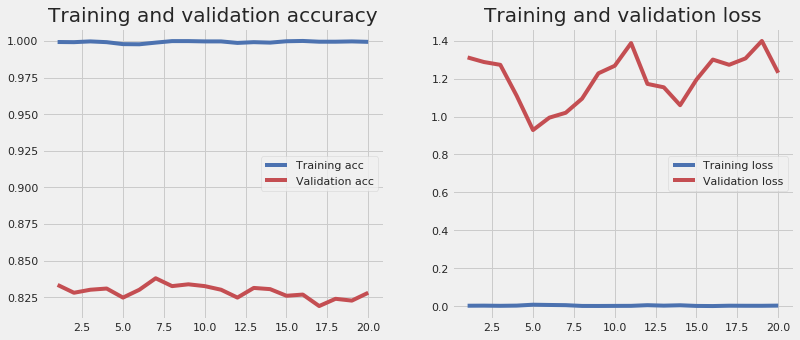

In [0]:
plot_history(historyLSTM1)

According to the RealPython tutorial in the link above, a good way to see when the model starts overfitting is when the loss of validation starts rising again. This is around Epoch 5-6 based on the graph. So let's train the model with 6 epochs and see how it comapres to the one with 2

In [0]:
# Training with 3 epochs
print('Train...')
historyLSTM1 = LSTM1.fit(X_train, Y_train, batch_size=batch_size, epochs=6,shuffle=True, validation_data=(X_test, Y_test))
print('Model evaluation ', LSTM1.evaluate(X_test,Y_test))

# Printing test score and accuracy with 3 epochs
score, acc = LSTM1.evaluate(X_test, Y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Train on 9692 samples, validate on 2424 samples
Epoch 1/6
9692/9692 [==============================] - 32s 3ms/step - loss: 0.0036 - acc: 0.9991 - val_loss: 1.1346 - val_acc: 0.8238
Epoch 2/6
9692/9692 [==============================] - 32s 3ms/step - loss: 0.0010 - acc: 0.9998 - val_loss: 1.2234 - val_acc: 0.8304
Epoch 3/6
9692/9692 [==============================] - 33s 3ms/step - loss: 1.3541e-04 - acc: 1.0000 - val_loss: 1.2770 - val_acc: 0.8263
Epoch 4/6
9692/9692 [==============================] - 32s 3ms/step - loss: 4.2571e-05 - acc: 1.0000 - val_loss: 1.3168 - val_acc: 0.8271
Epoch 5/6
9692/9692 [==============================] - 33s 3ms/step - loss: 1.3485e-05 - acc: 1.0000 - val_loss: 1.3309 - val_acc: 0.8284
Epoch 6/6
2424/2424 [==============================] - 1s 352us/step
Model evaluation  [1.3480209245933559, 0.8304455445544554]
2424/2424 [==============================] - 1s 361us/step
Test score: 1.3480209260072449
Test accuracy: 0.8304455376202518


With 6 epochs we got a slightly higher accuracy without overfitting

In [0]:
LSTM1_Metrics = LSTM1.predict(X_test, verbose=2, batch_size=batch_size)
print(metrics.classification_report(Y_test[:,1], np.round(LSTM1_Metrics[:,1]), target_names =["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.81      0.82      0.81      1097
    Positive       0.85      0.84      0.84      1327

    accuracy                           0.83      2424
   macro avg       0.83      0.83      0.83      2424
weighted avg       0.83      0.83      0.83      2424



### Experiementing with other LSTM models (reduced)

Now that we know the 'best' number of epochs for the reduced LSTM set, let's make a few more models and change some things to see if we can get better results

Changing the Conv1D layer to have a sigmoid activation and the density layer to have the softplus activation function

In [0]:
def lstmReduced2():
# Inform that the model is building
  print('Build model...')

  model = Sequential()

  # Add the embedding layer
  model.add(Embedding(max_features, embedding_size, input_length=maxlen))
  model.add(Dropout(0.25))
  # 1D Convolution Layer with Sigmoid activation
  model.add(Conv1D(filters, kernel_size, padding='valid', activation='sigmoid', strides=1))
  model.add(MaxPooling1D(pool_size=pool_size))

  # Add LSTM Layer
  model.add(LSTM(lstm_output_size))

  # Use the Softplus activiation function
  model.add(Dense(2,activation='softplus'))

  # Using categorical corss entropy and the SGD optimizer
  model.compile(loss = 'categorical_crossentropy', optimizer='SGD',metrics = ['accuracy'])

  # Print a summar of the model
  print(model.summary())

  return model

Building the second LSTM model

In [0]:
LSTM2 = lstmReduced2()

Build model...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 64)            41024     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                37800     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 142       
Total params: 2,638,966
Trainable params: 2,638,966
Non-trainable params: 0
_____________________________

Training the second model with 6 epochs

In [0]:
print('Train...')
LSTM2.fit(X_train, Y_train, batch_size=batch_size, epochs=6,shuffle=True, validation_data=(X_test, Y_test))
print('Model evaluation ',LSTM2.evaluate(X_test,Y_test))

Train...
Train on 9692 samples, validate on 2424 samples
Epoch 1/6
9692/9692 [==============================] - 26s 3ms/step - loss: 0.6878 - acc: 0.5543 - val_loss: 0.6908 - val_acc: 0.5474
Epoch 2/6
9692/9692 [==============================] - 25s 3ms/step - loss: 0.6879 - acc: 0.5543 - val_loss: 0.6895 - val_acc: 0.5474
Epoch 3/6
9692/9692 [==============================] - 25s 3ms/step - loss: 0.6879 - acc: 0.5543 - val_loss: 0.6898 - val_acc: 0.5474
Epoch 4/6
9692/9692 [==============================] - 25s 3ms/step - loss: 0.6878 - acc: 0.5543 - val_loss: 0.6917 - val_acc: 0.5474
Epoch 5/6
9692/9692 [==============================] - 25s 3ms/step - loss: 0.6879 - acc: 0.5543 - val_loss: 0.6898 - val_acc: 0.5474
Epoch 6/6
2424/2424 [==============================] - 1s 362us/step
Model evaluation  [0.6894458282505325, 0.5474422441260649]


Printing the results of model 2

In [0]:
# Printing test score and accuracy of the second LSTM model
score, acc = LSTM2.evaluate(X_test, Y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Getting the classification report of LSTM model 2
LSTM2_Metrics = LSTM2.predict(X_test, verbose=2, batch_size=batch_size)
print(metrics.classification_report(Y_test[:,1], np.round(LSTM2_Metrics[:,1]), target_names =["Negative", "Positive"]))

2424/2424 [==============================] - 1s 381us/step
Test score: 0.6894458260866675
Test accuracy: 0.547442253052008
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      1097
    Positive       0.55      1.00      0.71      1327

    accuracy                           0.55      2424
   macro avg       0.27      0.50      0.35      2424
weighted avg       0.30      0.55      0.39      2424



The above results for model 2 were lacking compared to the first LSTM. Let's make another model to see if we can improve it

Changing the Conv1D layer to have a linear activation and the density layer to have the softsign activation function. Also changed the optimizer to Adadelta

In [0]:
def lstmReduced3():
# Inform that the model is building
  print('Build model...')

  model = Sequential()

  # Add the embedding layer
  model.add(Embedding(max_features, embedding_size, input_length=maxlen))
  model.add(Dropout(0.25))
  # 1D Convolution Layer with Relu activation
  model.add(Conv1D(filters, kernel_size, padding='valid', activation='linear', strides=1))
  model.add(MaxPooling1D(pool_size=pool_size))

  # Add LSTM Layer
  model.add(LSTM(lstm_output_size))

  # Use the Softsign activiation function
  model.add(Dense(2,activation='softsign'))

  # Using categorical corss entropy and the Adadelta optimizer
  model.compile(loss = 'categorical_crossentropy', optimizer='Adadelta',metrics = ['accuracy'])

  # Print a summar of the model
  print(model.summary())

  return model

Building the model

In [0]:
LSTM3 = lstmReduced3()

Build model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 96, 64)            41024     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 70)                37800     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 142       
Total params: 2,638,966
Trainable params: 2,638,966
Non-trainable params: 0
_____________________________

Train the third LSTM model with 6 epochs


In [0]:
print('Train...')
LSTM3.fit(X_train, Y_train, batch_size=batch_size, epochs=6,shuffle=True, validation_data=(X_test, Y_test))
print('Model evaluation ',LSTM3.evaluate(X_test,Y_test))

Train...
Train on 9692 samples, validate on 2424 samples
Epoch 1/6
9692/9692 [==============================] - 36s 4ms/step - loss: 7.6466 - acc: 0.5543 - val_loss: 7.4651 - val_acc: 0.5470
Epoch 2/6
9692/9692 [==============================] - 33s 3ms/step - loss: 7.6649 - acc: 0.5543 - val_loss: 7.4651 - val_acc: 0.5470
Epoch 3/6
9692/9692 [==============================] - 34s 4ms/step - loss: 7.6632 - acc: 0.5543 - val_loss: 7.4651 - val_acc: 0.5470
Epoch 4/6
9692/9692 [==============================] - 34s 3ms/step - loss: 7.6566 - acc: 0.5543 - val_loss: 7.4651 - val_acc: 0.5470
Epoch 5/6
9692/9692 [==============================] - 34s 4ms/step - loss: 8.8053 - acc: 0.4559 - val_loss: 8.8503 - val_acc: 0.4526
Epoch 6/6
2424/2424 [==============================] - 1s 376us/step
Model evaluation  [0.6919370938842446, 0.45627062725942125]


Printing the results of LSTM model 3

In [0]:
# Printing test score and accuracy of the third LSTM model
score, acc = LSTM3.evaluate(X_test, Y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

2424/2424 [==============================] - 1s 389us/step
Test score: 0.6919370966382546
Test accuracy: 0.4562706356075141


Has a worse Accuracy the LSTM Reduced 2. So based on our expeirments on the reduced set. **LSTM Model 1 has the best results of the reduced set.** Expeirments with the full data set are in the Section "Full Data Work"

### Setting up the Data for CNN (Reduced)

Initalizing the variables for the CNN model. Numbers taken from [here](https://keras.io/examples/imdb_cnn/)

In [0]:
# Note some parameters were changed to be more consistent with the LSTM 
# experiements so we could have an accurate comaprison
max_features = 20000
maxlen = 100
batch_size = 30
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 2

### CNN Model and Results

Creating the function for the first CNN model. Based off the link above. It is a sequential model with 9 layers. The code section below this also trains the model on 2 epochs

In [0]:
def cnnReduced1():
  print('Build model...')
  model = Sequential()

  # we start off with an efficient embedding layer which maps
  # our vocab indices into embedding_dims dimensions
  model.add(Embedding(max_features,
                      embedding_dims,
                      input_length=maxlen))
  model.add(Dropout(0.2))

  # we add a Convolution1D, which will learn filters
  # word group filters of size filter_length:
  model.add(Conv1D(filters,
                  kernel_size,
                  padding='valid',
                  activation='relu',
                  strides=1))
  # we use max pooling:
  model.add(GlobalMaxPooling1D())

  # We add a vanilla hidden layer:
  model.add(Dense(hidden_dims))
  model.add(Dropout(0.2))
  model.add(Activation('relu'))

  # We project onto a single unit output layer, and squash it with a sigmoid:
  model.add(Dense(2))
  model.add(Activation('sigmoid'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  
  print(model.summary())
  
  return model

Building the model

In [0]:
CNN1 = cnnReduced1()

Build model...
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 50)           1000000   
_________________________________________________________________
dropout_13 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 98, 250)           37750     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 250)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_14 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_9 (Activation)    (None, 250

Training the model

In [0]:
print('Train...')
CNN1.fit(X_train, Y_train, batch_size=batch_size, epochs=2,shuffle=True, validation_data=(X_test, Y_test))
print('Model evaluation ',CNN1.evaluate(X_test,Y_test))

Train...
Train on 9692 samples, validate on 2424 samples
Epoch 1/2
9692/9692 [==============================] - 16s 2ms/step - loss: 0.5372 - acc: 0.7135 - val_loss: 0.3929 - val_acc: 0.8193
Epoch 2/2
2424/2424 [==============================] - 1s 225us/step
Model evaluation  [0.35363322329206437, 0.8424092407273774]


Printing the results of the first CNN model (reduced)

In [0]:
# Printing the accuracy and test score of the first CNN1 model
score, acc = CNN1.evaluate(X_test, Y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Getting the classification metrics of CNN1 model 
CNN1_Metrics = CNN1.predict(X_test, verbose = 2, batch_size = batch_size)
print(metrics.classification_report(Y_test[:,1], np.round(CNN1_Metrics[:,1]) ,target_names = ["Negative", "Positive"]))

2424/2424 [==============================] - 1s 239us/step
Test score: 0.3536332207962428
Test accuracy: 0.8424092371865074
              precision    recall  f1-score   support

    Negative       0.62      0.98      0.76      1097
    Positive       0.97      0.51      0.67      1327

    accuracy                           0.72      2424
   macro avg       0.79      0.74      0.71      2424
weighted avg       0.81      0.72      0.71      2424



### Experiementing with Different CNN Epochs (reduced)

Like with our LSTM data, we're going to increase the number of Epochs so we can see where the data starts to overfit. To keep it a fair comparison, we will train our first model on 20 epochs and see if it has a different point of overfitting compared to LSTM

In [0]:
# Training with 17 more epochs
print('Train...')
historyCNN1 = CNN1.fit(X_train, Y_train, batch_size=batch_size, epochs=20,shuffle=True, validation_data=(X_test, Y_test))
print('Model evaluation ', CNN1.evaluate(X_test,Y_test))

# Printing test score and accuracy with 20 epochs
score, acc = CNN1.evaluate(X_test, Y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Train on 9692 samples, validate on 2424 samples
Epoch 1/20
9692/9692 [==============================] - 14s 1ms/step - loss: 0.1594 - acc: 0.9431 - val_loss: 0.3946 - val_acc: 0.8424
Epoch 2/20
9692/9692 [==============================] - 14s 1ms/step - loss: 0.0662 - acc: 0.9786 - val_loss: 0.5257 - val_acc: 0.8292
Epoch 3/20
9692/9692 [==============================] - 14s 1ms/step - loss: 0.0285 - acc: 0.9913 - val_loss: 0.7054 - val_acc: 0.8185
Epoch 4/20
9692/9692 [==============================] - 14s 1ms/step - loss: 0.0149 - acc: 0.9957 - val_loss: 0.7351 - val_acc: 0.8280
Epoch 5/20
9692/9692 [==============================] - 14s 1ms/step - loss: 0.0077 - acc: 0.9972 - val_loss: 0.8805 - val_acc: 0.8156
Epoch 6/20
9692/9692 [==============================] - 14s 1ms/step - loss: 0.0106 - acc: 0.9961 - val_loss: 1.0940 - val_acc: 0.8189
Epoch 7/20
9692/9692 [==============================] - 14s 1ms/step - loss: 0.0235 - acc: 0.9920 - val_loss: 0.8887 - val_acc: 0.808

Calling the plot function

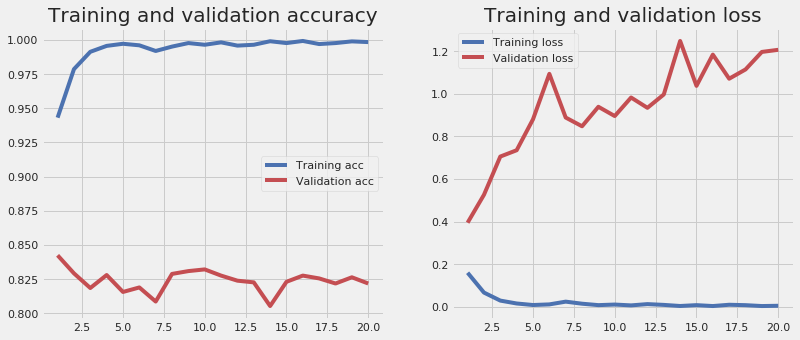

In [0]:
plot_history(historyCNN1)

The graph above provides more interesting results compared to the LSTM one. Since we're looking for when "the validation loss starts rising again" I think around the 4-5 epoch range is the right spot. Let's test with 5 and see how it compares to the 2 

In [0]:
# Training with 3 more epochs
print('Train...')
historyCNN1 = CNN1.fit(X_train, Y_train, batch_size=batch_size, epochs=5,shuffle=True, validation_data=(X_test, Y_test))
print('Model evaluation ', CNN1.evaluate(X_test,Y_test))

# Printing test score and accuracy with 5 epochs
score, acc = CNN1.evaluate(X_test, Y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Train on 9692 samples, validate on 2424 samples
Epoch 1/5
9692/9692 [==============================] - 14s 1ms/step - loss: 0.0021 - acc: 0.9993 - val_loss: 1.1968 - val_acc: 0.8238
Epoch 2/5
9692/9692 [==============================] - 15s 2ms/step - loss: 9.5971e-04 - acc: 0.9996 - val_loss: 1.4919 - val_acc: 0.8168
Epoch 3/5
9692/9692 [==============================] - 14s 1ms/step - loss: 1.5018e-04 - acc: 1.0000 - val_loss: 1.6479 - val_acc: 0.8177
Epoch 4/5
9692/9692 [==============================] - 14s 1ms/step - loss: 0.0039 - acc: 0.9992 - val_loss: 1.2124 - val_acc: 0.8243
Epoch 5/5
2424/2424 [==============================] - 1s 236us/step
Model evaluation  [1.424354098024148, 0.8168316833650319]
2424/2424 [==============================] - 1s 241us/step
Test score: 1.4243466608447604
Test accuracy: 0.8168316805126643


Getting Classification Metrics with 5 Epochs for CNN

In [0]:
# Getting the classification metrics of CNN1 model 
CNN1_Metrics = CNN1.predict(X_test, verbose = 2, batch_size = batch_size)
print(metrics.classification_report(Y_test[:,1], np.round(CNN1_Metrics[:,1]) ,target_names = ["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.80      0.79      0.80      1097
    Positive       0.83      0.84      0.83      1327

    accuracy                           0.82      2424
   macro avg       0.82      0.82      0.82      2424
weighted avg       0.82      0.82      0.82      2424



The results above with 5 epochs are more higher in both accuracy, precision, and recall comapred to the CNN with 2. The increase in numbers is a bit more drastic compared to LSTM. Let's run some experiements with CNN now that we discovered the 'right' number of epochs (5)

### Experimenting with other CNN Models (reduced)

Now that we know the 'best' number of epochs for the reduced CNN set, let's make a few more models and change some things to see if we can get better results.

To get a more accurate comparison between the two models (LSTM and CNN), We will run the same experiements on both. 

Making the CNN model 2 and replacing relu with sigmoid, adding the softplus activation function, and changing the optimizer to SGD. 

In [0]:
def cnnReduced2():
  print('Build model...')
  model = Sequential()

  # we start off with an efficient embedding layer which maps
  # our vocab indices into embedding_dims dimensions
  model.add(Embedding(max_features,
                      embedding_dims,
                      input_length=maxlen))
  model.add(Dropout(0.2))

  # we add a Convolution1D, which will learn filters
  # word group filters of size filter_length:
  model.add(Conv1D(filters,
                  kernel_size,
                  padding='valid',
                  activation='sigmoid',
                  strides=1))
  # we use max pooling:
  model.add(GlobalMaxPooling1D())

  # We add a vanilla hidden layer:
  model.add(Dense(hidden_dims))
  model.add(Dropout(0.2))
  model.add(Activation('sigmoid'))

  # We project onto a single unit output layer, and squash it with a sigmoid:
  model.add(Dense(2))
  model.add(Activation('softplus'))

  model.compile(loss='categorical_crossentropy',
                optimizer='SGD',
                metrics=['accuracy'])
  
  print(model.summary())
  
  return model

Building the model

In [0]:
CNN2 = cnnReduced2()

Build model...
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 50)           1000000   
_________________________________________________________________
dropout_15 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 98, 250)           37750     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 250)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_16 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_11 (Activation)   (None, 25

Training our model with 5 epochs

In [0]:
print('Train...')
CNN2.fit(X_train, Y_train, batch_size=batch_size, epochs=5,shuffle=True, validation_data=(X_test, Y_test))
print('Model evaluation ',CNN2.evaluate(X_test,Y_test))

Train...
Train on 9692 samples, validate on 2424 samples
Epoch 1/5
9692/9692 [==============================] - 14s 1ms/step - loss: 0.6902 - acc: 0.5470 - val_loss: 0.6919 - val_acc: 0.5474
Epoch 2/5
9692/9692 [==============================] - 12s 1ms/step - loss: 0.6902 - acc: 0.5454 - val_loss: 0.6986 - val_acc: 0.5474
Epoch 3/5
9692/9692 [==============================] - 12s 1ms/step - loss: 0.6903 - acc: 0.5498 - val_loss: 0.7030 - val_acc: 0.4526
Epoch 4/5
9692/9692 [==============================] - 12s 1ms/step - loss: 0.6897 - acc: 0.5469 - val_loss: 0.6911 - val_acc: 0.5474
Epoch 5/5
2424/2424 [==============================] - 1s 232us/step
Model evaluation  [0.7069395823840654, 0.4525577555788626]


Printing the results of our second CNN model

In [0]:
# Printing the accuracy and test score of the second CNN model
score, acc = CNN2.evaluate(X_test, Y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Getting the classification metrics of CNN1 model 
CNN2_Metrics = CNN2.predict(X_test, verbose = 2, batch_size = batch_size)
print(metrics.classification_report(Y_test[:,1], np.round(CNN2_Metrics[:,1]) ,target_names = ["Negative", "Positive"]))

2424/2424 [==============================] - 1s 252us/step
Test score: 0.7069395882363366
Test accuracy: 0.4525577638040085
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      1097
    Positive       0.55      1.00      0.71      1327

    accuracy                           0.55      2424
   macro avg       0.27      0.50      0.35      2424
weighted avg       0.30      0.55      0.39      2424



Like LSTM. The changes to the relu activation function and Adam Optimizer produce much worse results. Let's make another model

Making another model, changing the sigmoid form CNN2 to linear and the optimizer to Adadelta

In [0]:
def cnnReduced3():
  print('Build model...')
  model = Sequential()

  # we start off with an efficient embedding layer which maps
  # our vocab indices into embedding_dims dimensions
  model.add(Embedding(max_features,
                      embedding_dims,
                      input_length=maxlen))
  model.add(Dropout(0.2))

  # we add a Convolution1D, which will learn filters
  # word group filters of size filter_length:
  model.add(Conv1D(filters,
                  kernel_size,
                  padding='valid',
                  activation='linear',
                  strides=1))
  # we use max pooling:
  model.add(GlobalMaxPooling1D())

  # We add a vanilla hidden layer:
  model.add(Dense(hidden_dims))
  model.add(Dropout(0.2))
  model.add(Activation('linear'))

  # We project onto a single unit output layer, and squash it with a sigmoid:
  model.add(Dense(2))
  model.add(Activation('softsign'))

  model.compile(loss='categorical_crossentropy',
                optimizer='Adadelta',
                metrics=['accuracy'])
  
  print(model.summary())
  
  return model

Builiding the model

In [0]:
CNN3 = cnnReduced3()

Build model...
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 50)           1000000   
_________________________________________________________________
dropout_17 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 98, 250)           37750     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 250)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_18 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_13 (Activation)   (None, 25

Training the model with 5 epochs

In [0]:
print('Train...')
CNN3.fit(X_train, Y_train, batch_size=batch_size, epochs=5,shuffle=True, validation_data=(X_test, Y_test))
print('Model evaluation ',CNN3.evaluate(X_test,Y_test))

Train...
Train on 9692 samples, validate on 2424 samples
Epoch 1/5
9692/9692 [==============================] - 16s 2ms/step - loss: 1.2844 - acc: 0.6126 - val_loss: 1.9085 - val_acc: 0.6881
Epoch 2/5
9692/9692 [==============================] - 15s 1ms/step - loss: 0.6343 - acc: 0.7811 - val_loss: 0.7647 - val_acc: 0.8020
Epoch 3/5
9692/9692 [==============================] - 15s 2ms/step - loss: 0.6179 - acc: 0.8228 - val_loss: 0.7707 - val_acc: 0.8086
Epoch 4/5
9692/9692 [==============================] - 14s 1ms/step - loss: 0.5431 - acc: 0.8430 - val_loss: 0.7829 - val_acc: 0.8156
Epoch 5/5
2424/2424 [==============================] - 1s 247us/step
Model evaluation  [0.8473704643916375, 0.8217821784145368]


Getting the result of CNN 3

In [0]:
# Printing the accuracy and test score of the third CNN model
score, acc = CNN2.evaluate(X_test, Y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

2424/2424 [==============================] - 1s 257us/step
Test score: 0.7069395882363366
Test accuracy: 0.4525577638040085


The accuracy wasn't as bad compared to LSTM3, but it was not as high as CNN1. For the reduced CNN data, CNN1 still provides the best results

#**Full Data Work**

### Working with the full data

Reading the full data set and using the review and rating column

In [0]:
y = []
X = []
# open reduced CSV
with open('full_amazon_ff_reviews.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        X.append(row[5])
        y.append(row[8])

Making a data frame called 'dfFull' that is using columns 5 and 8 of the full data

In [0]:
# columns 'Rating' and 'Text' are loaded into the df
dfFull = pd.read_csv('full_amazon_ff_reviews.csv', usecols=[5, 8])

# seeing the top 5 records
dfFull.head()

,Rating,Text
0,positive,I have bought several of the Vitality canned d...
1,negative,Product arrived labeled as Jumbo Salted Peanut...
2,positive,This is a confection that has been around a fe...
3,negative,If you are looking for the secret ingredient i...
4,positive,Great taffy at a great price. There was a wid...


### Setting up the Data for LTSM (full)

Initalizing the variables for the LSTM Model. Numbers taken from the docs located [here](https://keras.io/examples/imdb_cnn_lstm/)

In [0]:
# For Embedding
max_features = 20000
maxlen = 100
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 2

Getting the data ready for emebdding, filtered out neutural reviews, number, speical characters, stopwords and converted to lowercase for better reading. Similar to the beginning of the notebook, except this time it's for the data frame containing the full data

In [0]:
# Filtering out neutral
dfFull = dfFull[dfFull.Rating != "neutral"]

# Converting all the lowercase
dfFull['Text'] = dfFull['Text'].apply(lambda x: str(x).lower())

# Removing numbers and special cases
dfFull['Text'] = dfFull['Text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

Counting the number of positive and negative reviews in the full data

In [0]:
# Number of positive reviews
print(dfFull[ dfFull['Rating'] == 'positive'].size)

# Number of negative reviews
print(dfFull[ dfFull['Rating'] == 'negative'].size)

750646
164074


Toeknizing the data for word embeddings with the full data. Lossely modeled after the solutions in this [link](https://stackoverflow.com/questions/55578939/tokenize-each-row-in-a-dataframe-for-loop-not-working)

In [0]:
for idx,row in dfFull.iterrows():
    row[0] = row[0].replace('rt',' ')
    
tokenizer = Tokenizer(nb_words = max_features, split=' ')
tokenizer.fit_on_texts(dfFull['Text'].values)
X = tokenizer.texts_to_sequences(dfFull['Text'].values)
X = pad_sequences(X, maxlen = maxlen)

Using get_dummies to convert the categorical text data into indicator variables. Based off the documentation [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)

In [0]:
# Call the get_dummies function
Y = pd.get_dummies(dfFull['Rating']).values

# Performing an 80/20 split with a random state of 42
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)

# Printing the shape of both the training and testing data
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(365888, 100) (365888, 2)
(91472, 100) (91472, 2)


### LSTM Model and Results for the Full Data

Building the First LSTM Full Model. It's a sequential model with 6 layers

In [0]:
def lstmFull1():
# Inform that the model is building
  print('Build model...')

  model = Sequential()

  # Add the embedding layer
  model.add(Embedding(max_features, embedding_size, input_length=maxlen))
  model.add(Dropout(0.25))
  # 1D Convolution Layer with Relu activation
  model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
  model.add(MaxPooling1D(pool_size=pool_size))

  # Add LSTM Layer
  model.add(LSTM(lstm_output_size))

  # Use the Softmask activiation function
  model.add(Dense(2,activation='softmax'))

  # Using categorical corss entropy and the adam optimizer
  model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

  # Print a summar of the model
  print(model.summary())

  return model

Call the lstmFull1 function to the variable LSTM_Full1

In [0]:
LSTM_Full1 = lstmFull1()

Build model...
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 128)          2560000   
_________________________________________________________________
dropout_19 (Dropout)         (None, 100, 128)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 98, 250)           96250     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 24, 250)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 70)                89880     
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 142       
Total params: 2,746,272
Trainable params: 2,746,272
Non-trainable params: 0
____________________________

Training the LSTM_Full1 model with a Batch size of 30 and 2 Epochs

In [0]:
print('Train...')
LSTM_Full1.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,shuffle=True, validation_data=(X_test, Y_test))
print('Model evaluation ',LSTM_Full1.evaluate(X_test,Y_test))

Train...
Train on 365888 samples, validate on 91472 samples
Epoch 1/2
365888/365888 [==============================] - 1701s 5ms/step - loss: 0.1686 - acc: 0.9346 - val_loss: 0.1282 - val_acc: 0.9515
Epoch 2/2
91472/91472 [==============================] - 63s 687us/step
Model evaluation  [0.11871898203217651, 0.9554508483470352]


Printing test score and test accuracy. Along with the classification report.

In [0]:
score, acc = LSTM_Full1.evaluate(X_test, Y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

LSTM_Full1_Metrics = LSTM_Full1.predict(X_test, verbose=2, batch_size =batch_size)
print(metrics.classification_report(Y_test[:,1], np.round(LSTM_Full1_Metrics[:,1]), target_names = ["Negative", "Positive"]))

91472/91472 [==============================] - 63s 687us/step
Test score: 0.11871898241894133
Test accuracy: 0.9554508369958795
              precision    recall  f1-score   support

    Negative       0.90      0.85      0.87     16421
    Positive       0.97      0.98      0.97     75051

    accuracy                           0.96     91472
   macro avg       0.93      0.91      0.92     91472
weighted avg       0.95      0.96      0.95     91472



### Experimenting with Different LSTM Epochs (Full)

Due to the long amount of time it takes for 2 epochs to run on the full data set (about 50 minutes per LSTM model), any graph we produce will not have enough data to determine the what number of epochs would be the best fit. So this section will be skipped for the LSTM Full Data and 2 epochs will be used in the experimentation section

### Experimenting with other LSTM models (Full)

To keep the results/comparisons as fair as possible. The LSTM full data will be undergoing the same tests as the LSTM reduced.

In [0]:
def lstmFull2():
# Inform that the model is building
  print('Build model...')

  model = Sequential()

  # Add the embedding layer
  model.add(Embedding(max_features, embedding_size, input_length=maxlen))
  model.add(Dropout(0.25))
  # 1D Convolution Layer with Sigmoid activation
  model.add(Conv1D(filters, kernel_size, padding='valid', activation='sigmoid', strides=1))
  model.add(MaxPooling1D(pool_size=pool_size))

  # Add LSTM Layer
  model.add(LSTM(lstm_output_size))

  # Use the Softplus activiation function
  model.add(Dense(2,activation='softplus'))

  # Using categorical corss entropy and the SGD optimizer
  model.compile(loss = 'categorical_crossentropy', optimizer='SGD',metrics = ['accuracy'])

  # Print a summar of the model
  print(model.summary())

  return model

Building the second LSTM Full Model

In [0]:
LSTM_Full2 = lstmFull2()

Build model...
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 128)          2560000   
_________________________________________________________________
dropout_20 (Dropout)         (None, 100, 128)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 98, 250)           96250     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 24, 250)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 70)                89880     
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 142       
Total params: 2,746,272
Trainable params: 2,746,272
Non-trainable params: 0
____________________________

Training the second model with 2 Epochs

In [0]:
print('Train...')
LSTM_Full2.fit(X_train, Y_train, batch_size=batch_size, epochs=2,shuffle=True, validation_data=(X_test, Y_test))
print('Model evaluation ',LSTM_Full2.evaluate(X_test,Y_test))

Train...
Train on 365888 samples, validate on 91472 samples
Epoch 1/2
365888/365888 [==============================] - 1445s 4ms/step - loss: 0.4708 - acc: 0.8207 - val_loss: 0.4711 - val_acc: 0.8205
Epoch 2/2
91472/91472 [==============================] - 64s 696us/step
Model evaluation  [0.4707737990832733, 0.8204805842224944]


Printing the results of LSTM Model 2 (Full)

In [0]:
score, acc = LSTM_Full2.evaluate(X_test, Y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


91472/91472 [==============================] - 64s 695us/step
Test score: 0.47077379915951245
Test accuracy: 0.8204805805643205


Compared to the first full LSTM Model, Model 2 took an over 10 point decrease in accuracy. While the results aren't as good as the first full model, the changed parameters are much more effective with the full data than the reduced

Making the third LSTM full model

In [0]:
def lstmFull3():
# Inform that the model is building
  print('Build model...')

  model = Sequential()

  # Add the embedding layer
  model.add(Embedding(max_features, embedding_size, input_length=maxlen))
  model.add(Dropout(0.25))
  # 1D Convolution Layer with Linear activation
  model.add(Conv1D(filters, kernel_size, padding='valid', activation='linear', strides=1))
  model.add(MaxPooling1D(pool_size=pool_size))

  # Add LSTM Layer
  model.add(LSTM(lstm_output_size))

  # Use the Softsign activiation function
  model.add(Dense(2,activation='softsign'))

  # Using categorical corss entropy and the Adadelta optimizer
  model.compile(loss = 'categorical_crossentropy', optimizer='Adadelta',metrics = ['accuracy'])

  # Print a summar of the model
  print(model.summary())

  return model

Building the model

In [0]:
LSTM_Full3 = lstmReduced3()

Build model...
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 128)          2560000   
_________________________________________________________________
dropout_21 (Dropout)         (None, 100, 128)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 98, 250)           96250     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 24, 250)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 70)                89880     
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 142       
Total params: 2,746,272
Trainable params: 2,746,272
Non-trainable params: 0
____________________________

Train the third LSTM full model with 2 epochs

In [0]:
print('Train...')
LSTM_Full3.fit(X_train, Y_train, batch_size=batch_size, epochs=2,shuffle=True, validation_data=(X_test, Y_test))
print('Model evaluation ',LSTM_Full3.evaluate(X_test,Y_test))

Train...
Train on 365888 samples, validate on 91472 samples
Epoch 1/2
365888/365888 [==============================] - 1824s 5ms/step - loss: 2.8907 - acc: 0.1794 - val_loss: 2.8935 - val_acc: 0.1795
Epoch 2/2
91472/91472 [==============================] - 62s 675us/step
Model evaluation  [2.893511081901238, 0.1795194157775057]


Printing the results of LSTM model 3

In [0]:
# Printing test score and accuracy of the third LSTM model
score, acc = LSTM_Full3.evaluate(X_test, Y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

91472/91472 [==============================] - 62s 678us/step
Test score: 2.8935110002641435
Test accuracy: 0.1795194208920419


This accuracy is comically low. So much like the redueced set. The relu activation provides the best results based on our LSTM expeirments

### Setting up the Data For CNN (Full)

Initalizing the variables for the CNN model. Numbers taken from [here](https://keras.io/examples/imdb_cnn/)

In [0]:
# Note some parameters were changed to be more consistent with the LSTM 
# experiements so we could have an accurate comaprison
max_features = 20000
maxlen = 100
batch_size = 30
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 2

### CNN Model and Results (Full)

Creating the function for the first CNN model. Based off the link above. It is a sequential model with 9 layer, it will run on 2 epochs

In [0]:
def cnnFull1():
  print('Build model...')
  model = Sequential()

  # we start off with an efficient embedding layer which maps
  # our vocab indices into embedding_dims dimensions
  model.add(Embedding(max_features,
                      embedding_dims,
                      input_length=maxlen))
  model.add(Dropout(0.2))

  # we add a Convolution1D, which will learn filters
  # word group filters of size filter_length:
  model.add(Conv1D(filters,
                  kernel_size,
                  padding='valid',
                  activation='relu',
                  strides=1))
  # we use max pooling:
  model.add(GlobalMaxPooling1D())

  # We add a vanilla hidden layer:
  model.add(Dense(hidden_dims))
  model.add(Dropout(0.2))
  model.add(Activation('relu'))

  # We project onto a single unit output layer, and squash it with a sigmoid:
  model.add(Dense(2))
  model.add(Activation('sigmoid'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  
  print(model.summary())
  
  return model

Building the first full CNN model

In [0]:
CNN_Full1 = cnnFull1()

Build model...
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 100, 50)           1000000   
_________________________________________________________________
dropout_26 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 98, 250)           37750     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 250)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_27 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_19 (Activation)   (None, 25

Training the model

In [0]:
print('Train...')
CNN_Full1.fit(X_train, Y_train, batch_size=batch_size, epochs=2,shuffle=True, validation_data=(X_test, Y_test))
print('Model evaluation ',CNN_Full1.evaluate(X_test,Y_test))

Train...
Train on 365888 samples, validate on 91472 samples
Epoch 1/2
365888/365888 [==============================] - 539s 1ms/step - loss: 0.1775 - acc: 0.9307 - val_loss: 0.1397 - val_acc: 0.9479
Epoch 2/2
91472/91472 [==============================] - 21s 226us/step
Model evaluation  [0.11456123066035542, 0.9577466328493965]


Printing the results

In [0]:
# Printing the accuracy and test score of the first CNN1 model
score, acc = CNN_Full1.evaluate(X_test, Y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Getting the classification metrics of CNN1 model 
CNN_Full1_Metrics = CNN_Full1.predict(X_test, verbose = 2, batch_size = batch_size)
print(metrics.classification_report(Y_test[:,1], np.round(CNN_Full1_Metrics[:,1]) ,target_names = ["Negative", "Positive"]))

91472/91472 [==============================] - 20s 220us/step
Test score: 0.1145612309263065
Test accuracy: 0.9577466215177893
              precision    recall  f1-score   support

    Negative       0.92      0.83      0.87     16421
    Positive       0.96      0.98      0.97     75051

    accuracy                           0.96     91472
   macro avg       0.94      0.91      0.92     91472
weighted avg       0.96      0.96      0.96     91472



### Experimentning with diffferent CNN Epochs (Full)

Since each Epoch takes about 11 minutes to run on the Full dataset with CNN, we can experiment a little bit. Let's run a 5 epoch model and compare it to the two

In [0]:
# Training with 3 more epochs
print('Train...')
historyCNN_Full1 = CNN_Full1.fit(X_train, Y_train, batch_size=batch_size, epochs=5,shuffle=True, validation_data=(X_test, Y_test))
print('Model evaluation ', CNN1.evaluate(X_test,Y_test))

# Printing test score and accuracy with 5 epochs
score, acc = CNN_Full1.evaluate(X_test, Y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Train on 365888 samples, validate on 91472 samples
Epoch 1/5
365888/365888 [==============================] - 529s 1ms/step - loss: 0.0924 - acc: 0.9667 - val_loss: 0.1152 - val_acc: 0.9576
Epoch 2/5
365888/365888 [==============================] - 527s 1ms/step - loss: 0.0760 - acc: 0.9728 - val_loss: 0.1118 - val_acc: 0.9604
Epoch 3/5
365888/365888 [==============================] - 527s 1ms/step - loss: 0.0641 - acc: 0.9773 - val_loss: 0.1195 - val_acc: 0.9602
Epoch 4/5
365888/365888 [==============================] - 536s 1ms/step - loss: 0.0545 - acc: 0.9805 - val_loss: 0.1387 - val_acc: 0.9601
Epoch 5/5
91472/91472 [==============================] - 20s 219us/step
Model evaluation  [2.7611035212616373, 0.6598193982858143]
91472/91472 [==============================] - 21s 226us/step
Test score: 0.11857182656177695
Test accuracy: 0.960097067308307


Accuracy has gone up a point with the increase in epochs

Calling the plot function

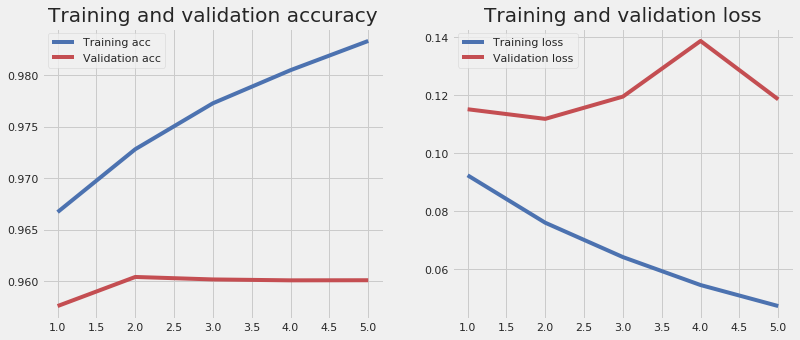

In [0]:
plot_history(historyCNN_Full1)

Although this graph isn't detailed as much as the earlier ones, based on where the validation loss begins to rise again, it looks like a good epoch selection for full CNN would be 3. Let's run some experiements with it.

### Experiementing with Other CNN Models (Reduced)

Experiements will be similar to the one in the earlier sections. Three epochs will be used for the other models.

In [0]:
def cnnFull2():
  print('Build model...')
  model = Sequential()

  # we start off with an efficient embedding layer which maps
  # our vocab indices into embedding_dims dimensions
  model.add(Embedding(max_features,
                      embedding_dims,
                      input_length=maxlen))
  model.add(Dropout(0.2))

  # we add a Convolution1D, which will learn filters
  # word group filters of size filter_length:
  model.add(Conv1D(filters,
                  kernel_size,
                  padding='valid',
                  activation='sigmoid',
                  strides=1))
  # we use max pooling:
  model.add(GlobalMaxPooling1D())

  # We add a vanilla hidden layer:
  model.add(Dense(hidden_dims))
  model.add(Dropout(0.2))
  model.add(Activation('sigmoid'))

  # We project onto a single unit output layer, and squash it with a sigmoid:
  model.add(Dense(2))
  model.add(Activation('softplus'))

  model.compile(loss='categorical_crossentropy',
                optimizer='SGD',
                metrics=['accuracy'])
  
  print(model.summary())
  
  return model

Building the model

In [0]:
CNN_Full2 = cnnFull2()

Build model...
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 100, 50)           1000000   
_________________________________________________________________
dropout_28 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 98, 250)           37750     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 250)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_29 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_21 (Activation)   (None, 25

Training the model with 3 epochs

In [0]:
print('Train...')
CNN_Full2.fit(X_train, Y_train, batch_size=batch_size, epochs=3,shuffle=True, validation_data=(X_test, Y_test))
print('Model evaluation ',CNN_Full2.evaluate(X_test,Y_test))

Train...
Train on 365888 samples, validate on 91472 samples
Epoch 1/3
365888/365888 [==============================] - 444s 1ms/step - loss: 0.4714 - acc: 0.8205 - val_loss: 0.4729 - val_acc: 0.8205
Epoch 2/3
365888/365888 [==============================] - 413s 1ms/step - loss: 0.4710 - acc: 0.8207 - val_loss: 0.4707 - val_acc: 0.8205
Epoch 3/3
91472/91472 [==============================] - 20s 221us/step
Model evaluation  [0.4706808225308262, 0.8204805842224944]


Printing the results

In [0]:
# Printing the accuracy and test score of the second CNN model
score, acc = CNN_Full2.evaluate(X_test, Y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


91472/91472 [==============================] - 21s 224us/step
Test score: 0.4706808223500027
Test accuracy: 0.8204805805643205


Making the third Full CNN model

In [0]:
def cnnFull3():
  print('Build model...')
  model = Sequential()

  # we start off with an efficient embedding layer which maps
  # our vocab indices into embedding_dims dimensions
  model.add(Embedding(max_features,
                      embedding_dims,
                      input_length=maxlen))
  model.add(Dropout(0.2))

  # we add a Convolution1D, which will learn filters
  # word group filters of size filter_length:
  model.add(Conv1D(filters,
                  kernel_size,
                  padding='valid',
                  activation='linear',
                  strides=1))
  # we use max pooling:
  model.add(GlobalMaxPooling1D())

  # We add a vanilla hidden layer:
  model.add(Dense(hidden_dims))
  model.add(Dropout(0.2))
  model.add(Activation('linear'))

  # We project onto a single unit output layer, and squash it with a sigmoid:
  model.add(Dense(2))
  model.add(Activation('softsign'))

  model.compile(loss='categorical_crossentropy',
                optimizer='Adadelta',
                metrics=['accuracy'])
  
  print(model.summary())
  
  return model

Building the model

In [0]:
CNN_Full3 = cnnFull3()

Build model...
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 100, 50)           1000000   
_________________________________________________________________
dropout_30 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 98, 250)           37750     
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 250)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_31 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_23 (Activation)   (None, 25

Training the model

In [0]:
# 3 Epochs Used
print('Train...')
CNN_Full3.fit(X_train, Y_train, batch_size=batch_size, epochs=3,shuffle=True, validation_data=(X_test, Y_test))
print('Model evaluation ',CNN_Full3.evaluate(X_test,Y_test))

Train...
Train on 365888 samples, validate on 91472 samples
Epoch 1/3
365888/365888 [==============================] - 557s 2ms/step - loss: 0.9108 - acc: 0.1272 - val_loss: 1.3246 - val_acc: 0.1153
Epoch 2/3
365888/365888 [==============================] - 554s 2ms/step - loss: 3.4855 - acc: 0.7659 - val_loss: 2.8935 - val_acc: 0.8205
Epoch 3/3
91472/91472 [==============================] - 21s 224us/step
Model evaluation  [nan, 0.1795194157775057]


Printing the results

In [0]:
# Printing the accuracy and test score of the second CNN model
score, acc = CNN_Full3.evaluate(X_test, Y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

91472/91472 [==============================] - 20s 223us/step
Test score: nan
Test accuracy: 0.1795194208920419


Based on all three models of Full CNN, Model 1 Full with 5 epochs returns the best data